In [1]:
!pip install visualkeras seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
!pip install sklearn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
!pip install visualkeras

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [5]:
tf.keras.backend.clear_session()

In [6]:
train_path = '../data/Coivd-19_Synthetic/GANGEN_2022-6-30-05-53_v5'
test_path = '../data/Covid-19 Image Dataset/test'

In [7]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [8]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

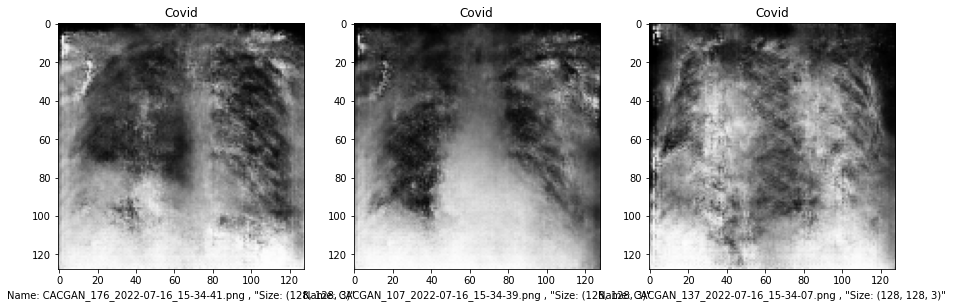

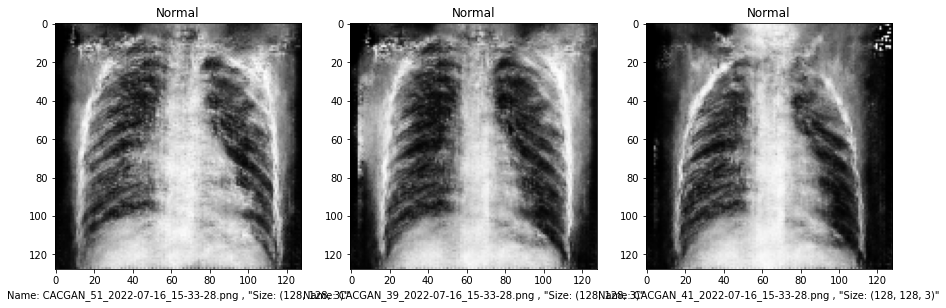

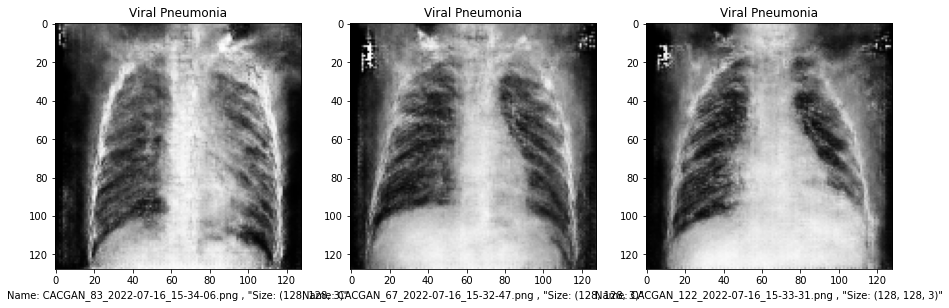

In [9]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [11]:
img_size = 128
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 2000 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [12]:
base_model = VGG16(weights='imagenet', include_top=False, pooling=None,
                            input_shape=(img_size, img_size, 3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512 , activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dropout(0.3)(x) # 2022年7月2日16点41分 to avoid underfitting
x = Dense(512 , activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dropout(0.3)(x) # 2022年7月2日16点41分 to avoid underfitting
x = Dense(256 , activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

2022-07-17 02:42:33.942910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 02:42:34.437208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43470 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [13]:
!pip install pydot

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [15]:
plot_model(model, to_file='../images/vgg_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


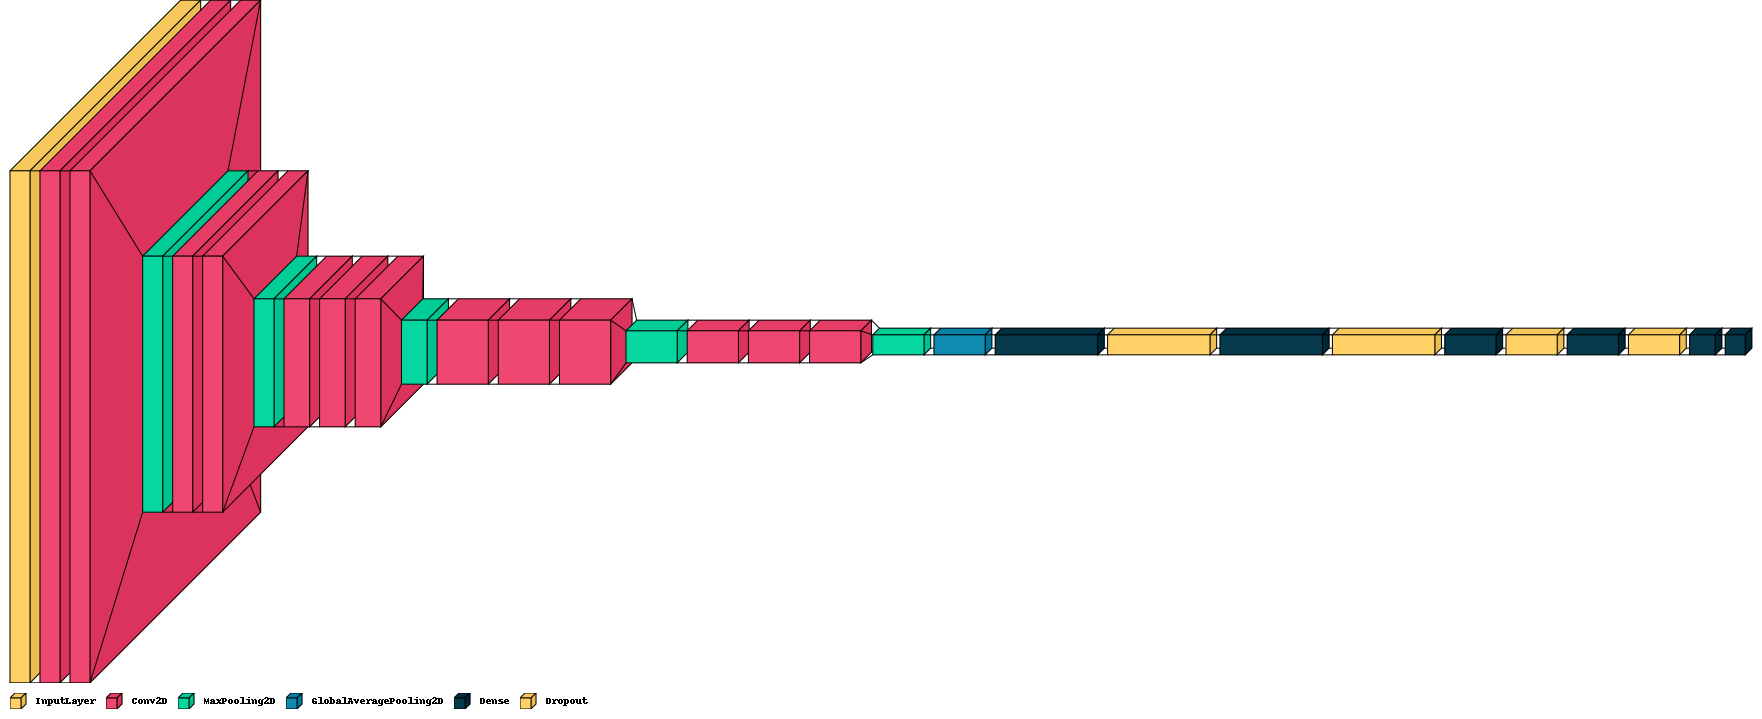

In [16]:
visualkeras.layered_view(model, legend=True)

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1), 
             ModelCheckpoint('../models/vgg_model_cacgan_v5.h5', save_best_only=True)]

In [18]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
DISABLE_GPU = False
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [20]:
history = model.fit(train_generator,
                    epochs = 320,
                    validation_data = test_generator,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/320


2022-07-17 02:42:38.273018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  4/125 [..............................] - ETA: 5s - loss: 1.1545 - accuracy: 0.3750

2022-07-17 02:42:39.807276: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


125/125 [==============================] - 13s 78ms/step - loss: 1.0630 - accuracy: 0.4530 - val_loss: 0.9439 - val_accuracy: 0.6364
Epoch 2/320
125/125 [==============================] - 9s 75ms/step - loss: 0.8700 - accuracy: 0.5860 - val_loss: 0.7319 - val_accuracy: 0.7879
Epoch 3/320
125/125 [==============================] - 9s 74ms/step - loss: 0.7681 - accuracy: 0.6670 - val_loss: 0.6538 - val_accuracy: 0.6818
Epoch 4/320
125/125 [==============================] - 9s 72ms/step - loss: 0.7281 - accuracy: 0.6815 - val_loss: 0.7267 - val_accuracy: 0.7273
Epoch 5/320
125/125 [==============================] - 9s 74ms/step - loss: 0.6739 - accuracy: 0.7145 - val_loss: 0.5536 - val_accuracy: 0.8030
Epoch 6/320
125/125 [==============================] - 9s 73ms/step - loss: 0.6797 - accuracy: 0.7170 - val_loss: 0.5982 - val_accuracy: 0.7273
Epoch 7/320
125/125 [==============================] - 9s 73ms/step - loss: 0.6612 - accuracy: 0.7160 - val_loss: 0.5813 - val_accuracy: 0.7424
Epo

In [21]:
model = load_model('../models/vgg_model_cacgan_v5.h5')

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

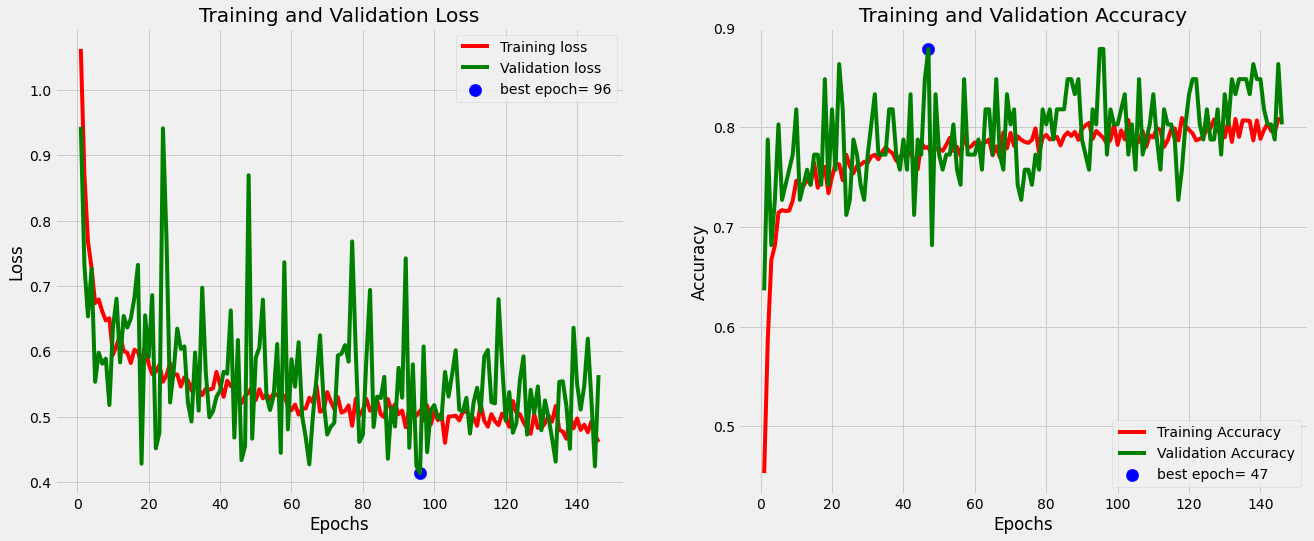

In [23]:
tr_plot(history, 0)

In [24]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 1s 18ms/step - loss: 0.4139 - accuracy: 0.8788
Loss: 41.389
Accuracy: 87.879


In [25]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

66/66 [==============================] - 1s 20ms/step


(array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int32))

In [26]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [27]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('../images/con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [28]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [29]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[25  1  1]
 [ 0 18  4]
 [ 1  1 15]]


F1 Score: 0.8804943144565787


                 precision    recall  f1-score   support

          Covid       0.96      0.93      0.94        27
         Normal       0.90      0.82      0.86        22
Viral Pneumonia       0.75      0.88      0.81        17

       accuracy                           0.88        66
      macro avg       0.87      0.88      0.87        66
   weighted avg       0.89      0.88      0.88        66



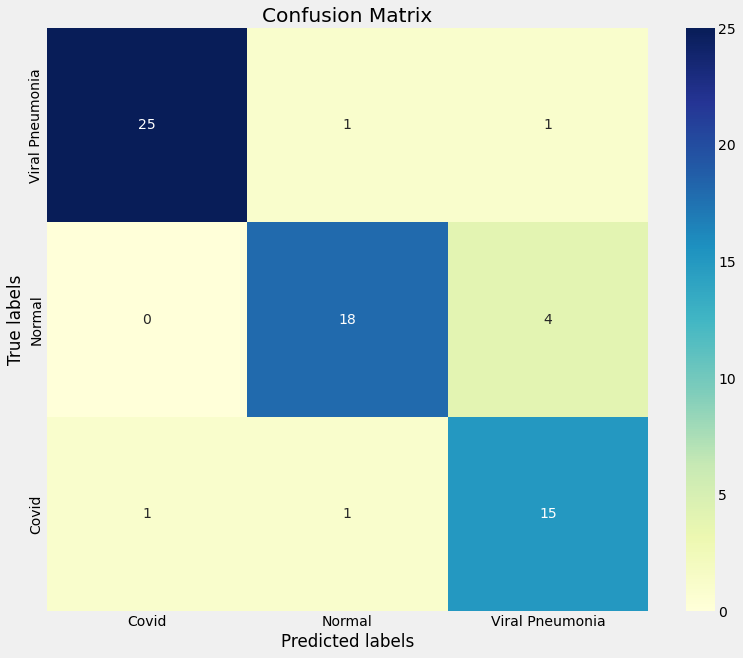

In [30]:
cal_score(model, plot=True)